## <center> **Livrable n°3 : Captioning d'image** </center>

‎ 

Réalisé par le **groupe n°2** :
- BERTHO Lucien
- BOSACKI Paul
- GAURE Warren
- GRENOUILLET Théo
- VALLEMONT Hugo


‎

---


### **Sommaire**

1. [Mise en contexte](#contexte)
2. [Objectif du livrable](#objectif)
3. [Importation des bibliothèques](#import)
4. [Prétraitement et exploration des données](#pretraitement)
5. [Item #5](#item5)
6. [Item #6](#item6)
7. [Item #7](#item7)
8. [Item #8](#item8)
9. [Item #9](#item9)
10. [Item #10](#item10)

‎ 

---

### 1. <a id='contexte'>Mise en contexte</a>

L’entreprise TouNum est spécialisée dans la numérisation de documents, qu’il s’agisse de textes ou d’images. Ses services sont particulièrement sollicités par des entreprises cherchant à transformer leur base documentaire papier en fichiers numériques exploitables. Aujourd’hui, TouNum souhaite aller plus loin en enrichissant son offre avec des outils basés sur le Machine Learning.

En effet, certains clients disposent d’un volume considérable de documents à numériser et expriment un besoin croissant pour des solutions de catégorisation automatique. Une telle innovation leur permettrait d’optimiser le traitement et l’exploitation de leurs données numérisées. Toutefois, TouNum ne dispose pas en interne des compétences nécessaires pour concevoir et mettre en place ces technologies.

C’est dans ce cadre que notre équipe de spécialistes en Data Science du CESI est sollicitée. Notre mission consiste à développer une première solution intégrant du captioning automatique : un système capable d’analyser des photographies et de générer une légende descriptive de manière autonome.

Heureusement, TouNum possède déjà plusieurs milliers d’images annotées, ce qui constituera une ressource précieuse pour entraîner les modèles de Machine Learning à partir d’un apprentissage supervisé.

---

### 2. <a id='objectif'>Objectif du livrable</a>

TODO

---

### 3. <a id='import'>Importation des bibliothèques</a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

from concurrent.futures import ThreadPoolExecutor, as_completed
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm

2025-04-17 06:25:53.563968: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-17 06:25:53.837245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744871153.933796     451 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744871153.960721     451 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744871154.259425     451 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            details = tf.config.experimental.get_device_details(gpu)
            print(f"Nom du GPU détecté : {details.get('device_name', 'Nom inconnu')}")
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Nom du GPU détecté : NVIDIA GeForce RTX 4060 Laptop GPU


---

### 4. <a id='pretraitement'>Prétraitement et exploration des données</a>

Une fois les bibliothèques importées, nous pouvons désormais gérer les données qui nous ont été données.

#### 4.1. <a>Vérification des images</a>

In [3]:
dataset_directory = "dataset_livrable_1/Photo/"
dataset_directory2 = "dataset_livrable_2/"

In [4]:
#def is_valid_image(path):
#    try:
#        img_raw = tf.io.read_file(path)
#        _ = tf.image.decode_image(img_raw, channels=3)
#        return (path, True)
#    except Exception:
#        return (path, False)
#
#def clean_corrupted_images(directory, extensions=("jpg", "jpeg", "png"), max_workers=8):
#    image_paths = []
#    for root, _, files in os.walk(directory):
#        for file in files:
#            if file.lower().endswith(extensions):
#                image_paths.append(os.path.join(root, file))
#
#    print(f"Scan de {len(image_paths)} images dans {directory}")
#
#    corrupted_count = 0
#    with ThreadPoolExecutor(max_workers=max_workers) as executor:
#        futures = [executor.submit(is_valid_image, path) for path in image_paths]
#        for future in as_completed(futures):
#            path, is_valid = future.result()
#            if not is_valid:
#                try:
#                    os.remove(path)
#                    corrupted_count += 1
#                except Exception as e:
#                    print(f"Erreur de suppression {path} : {e}")
#
#    print(f"Vérification terminée : {corrupted_count} image(s) corrompue(s) supprimée(s).")
#    
#
#clean_corrupted_images(dataset_directory)
#clean_corrupted_images(dataset_directory2)

---

#### 4.2. <a>Chargement des données</a>

In [5]:
image_h = 128
image_w = 128
batch_s = 16

dataset = keras.utils.image_dataset_from_directory(
    directory = dataset_directory,
    label_mode = None,
    batch_size = batch_s,
    image_size = (image_h, image_w),
    seed = 42
)

dataset_2 = keras.utils.image_dataset_from_directory(
    directory = dataset_directory2,
    label_mode = None,
    batch_size = batch_s,
    image_size = (image_h, image_w),
    seed = 42
)


Found 9993 files.


I0000 00:00:1744871185.001479     451 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 148 files.


---

#### 4.3. <a>Prétraitement des données</a>

Étant donné que nous travaillons à nouveau avec des images, c'est-à-dire des ensembles de pixels dont les valeurs sont comprises entre 0 et 255, nous devons les mettre à dans l'intervalle `[0, 1]` afin de mieux les traiter.

In [6]:
dataset = dataset.map(lambda x: tf.cast(x, tf.float32) / 255.0)
dataset_2 = dataset_2.map(lambda x: tf.cast(x, tf.float32) / 255.0)
X = []

for batch in dataset:
    X.append(batch.numpy())

for batch in dataset_2:
    X.append(batch.numpy())
    
dataset = np.concatenate(X)
print(dataset.shape)

2025-04-17 06:26:46.431015: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-17 06:26:46.707049: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(10141, 128, 128, 3)


---

#### 4.4. <a>Affichage des images</a>

Maintenant que le prétraitement est fait, nous pouvons afficher des images grâce à une fonction.

In [7]:
def display_images():
    plt.figure(figsize=(8, 8))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(dataset[i])
        plt.axis("off")
    plt.show()

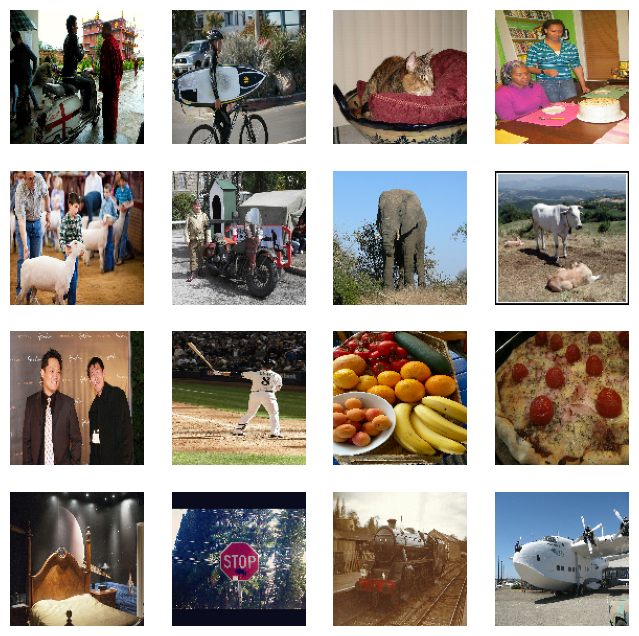

In [8]:
display_images()

#### Dossier d'annotation 

In [9]:
# Chemin du fichier d'annotations
annotation_file = "/tf/dataset_livrable_3/annotations/captions_train2014.json"

# Chemin du dossier contenant les images à annoter
PATH = '/tf/dataset_livrable_3/train2014/train2014/'
PATH2 = '/tf/dataset_livrable_2/Dataset/'


# Lecture du fichier d'annotation
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Grouper toutes les annotations ayant le meme identifiant.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    # marquer le debut et la fin de chaq0+ ue annotation
    caption = '<start> ' + val['caption'] + ' <end>'
    # L'identifiant d'une image fait partie de son chemin d'accès
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    #image_path = PATH2 + 'noisy_' + '%03d.jpg' % (val['image_id'])
    # Rajout du caption associé à image_path
    image_path_to_caption[image_path].append(caption)

# Print the first 10 values of image_path_to_caption
#for i, (key, value) in enumerate(image_path_to_caption.items()):
#    if os.path.exists(key):
#        if i == 10:
#            break
#        print(f"{key}: {value}")
#        img = Image.open(key)
#        plt.imshow(img)
#        plt.axis("off")
#        plt.show()
    
# Prendre les premières images seulement
image_paths = list(image_path_to_caption.keys())
train_image_paths = image_paths[:2000]

# Liste de toutes les annotations
train_captions = []
# Liste de tous les noms de fichiers des images dupliquées (en nombre d'annotations par image)
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    # Rajout de caption_list dans train_captions
    train_captions.extend(caption_list)
    # Rajout de image_path dupliquée len(caption_list) fois
    img_name_vector.extend([image_path] * len(caption_list))


In [10]:
# Telechargement du modèle InceptionV3 pré-entrainé avec la cassification sur ImageNet
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
# Creation d'une variable qui sera l'entrée du nouveau modèle de pre-traitement d'images
new_input = image_model.input
# récupérer la dernière couche caché qui contient l'image en representation compacte
hidden_layer = image_model.layers[-1].output

# Modèle qui calcule une representation dense des images avec InceptionV3
image_features_extract_model = tf.keras.Model(inputs = new_input, outputs = hidden_layer)

# Définition de la fonction load_image
def load_image(image_path):
    """
    La fonction load_image a pour entrée le chemin d'une image et pour sortie un couple
    contenant l'image traitée ainsi que son chemin d'accès.
    La fonction load_image effectue les traitement suivant:
        1. Chargement du fichier correspondant au chemin d'accès image_path
        2. Décodage de l'image en RGB.
        3. Redimensionnement de l'image en taille (299, 299).
        4. Normalisation des pîxels de l'image entre -1 et 1
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Pré-traitement des images
# Prendre les noms des images
encode_train = sorted(set(img_name_vector))

# Creation d'une instance de "tf.data.Dataset" partant des noms des images 
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# Division du données en batchs après application du pré-traitement fait par load_image
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Parcourir le dataset batch par batch pour effectuez le pré-traitement d'InceptionV3
for img, path in tqdm(image_dataset):
    # Pré-traitement du batch (de taille (16,8,8,2048)) courant par InceptionV3 
    batch_features = image_features_extract_model(img)
    # Resize du batch de taille (16,8,8,2048) en taille (16,64,2048)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    # Parcourir le batch courant et stocker le chemin ainsi que le batch avec np.save()
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        # (chemin de l'image associe a sa nouvelle representation , representation de l'image)
        np.save(path_of_feature, bf.numpy())

  0%|          | 0/125 [00:00<?, ?it/s]I0000 00:00:1744871215.185732     451 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-17 06:26:57.025223: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
100%|██████████| 125/125 [00:49<00:00,  2.51it/s]


In [11]:
# Trouver la taille maximale 
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Chosir les 5000 mots les plus frequents du vocabulaire
top_k = 5000
#La classe Tokenizer permet de faire du pre-traitement de texte pour reseau de neurones 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
# Construit un vocabulaire en se basant sur la liste train_captions
tokenizer.fit_on_texts(train_captions)
    
# Créer le token qui sert à remplir les annotations pour egaliser leurs longueur
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Creation des vecteurs(liste de token entiers) à partir des annotations (liste de mots)
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Remplir chaque vecteur à jusqu'à la longueur maximale des annotations
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calcule la longueur maximale qui est utilisée pour stocker les poids d'attention 
# Elle servira plus tard pour l'affichage lors de l'évaluation
max_length = calc_max_length(train_seqs)

#### 5. <a>Modèle de classification</a>

In [12]:
img_to_cap_vector = collections.defaultdict(list)
# Creation d'un dictionnaire associant les chemins des images avec (fichier .npy) aux annotationss
# Les images sont dupliquées car il y a plusieurs annotations par image
print(len(img_name_vector), len(cap_vector))
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

"""
Création des datasets de formation et de validation en utilisant 
un fractionnement 80-20 de manière aléatoire
""" 
# Prendre les clés (noms des fichiers d'images traites), *celles-ci ne seront pas dupliquées*
img_keys = list(img_to_cap_vector.keys())
#A COMPLETER
# Diviser des indices en entrainement et test
slice_index = int(len(img_keys) * 0.8)
img_name_train_keys = img_keys[:slice_index]
img_name_val_keys = img_keys[slice_index:]

"""
Les jeux d'entrainement et de tests sont sous forme
de listes contenants les mappings :(image prétraitée ---> jeton d'annotation(mot) )
"""

# Boucle pour construire le jeu d'entrainement
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    # Duplication des images en le nombre d'annotations par image
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

# Boucle pour construire le jeu de test
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

10005 10005


(8004, 8004, 2001, 2001)

In [13]:
# N'hésitez pas à modifier ces paramètres en fonction de votre machine
BATCH_SIZE = 64 # taille du batch
BUFFER_SIZE = 1000 # taille du buffer pour melanger les donnes
embedding_dim = 256
units = 512 # Taille de la couche caché dans le RNN
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# La forme du vecteur extrait à partir d'InceptionV3 est (64, 2048)
# Les deux variables suivantes representent la forme de ce vecteur
features_shape = 2048
attention_features_shape = 64

# Fonction qui charge les fichiers numpy des images prétraitées
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

# Creation d'un dataset de "Tensor"s (sert à representer de grands dataset)
# Le dataset est cree a partir de "img_name_train" et "cap_train"
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# L'utilisation de map permet de charger les fichiers numpy (possiblement en parallèle)
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Melanger les donnees et les diviser en batchs
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [14]:
class CNN_Encoder(tf.keras.Model):
    # Comme les images sont déjà prétraités par InceptionV3 est représenté sous forme compacte
    # L'encodeur CNN ne fera que transmettre ces caractéristiques à une couche dense
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # forme après fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

#### Decodeur/Encodeur

In [15]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) forme == (batch_size, 64, embedding_dim)

        # forme de la couche cachée == (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        attention_hidden_layer = tf.nn.tanh(
                self.W1(features) + self.W2(hidden_with_time_axis)
        )

        # Cela vous donne un score non normalisé pour chaque caractéristique de l'image.
        score = self.V(attention_hidden_layer)

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

In [16]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        self.gru = tf.keras.layers.GRU(
            self.units,
            return_sequences=True,
            return_state=True,
            #recurrent_initializer='glorot_uniform',
            
            activation='tanh',
            recurrent_activation='sigmoid',
            use_bias=True,
            kernel_initializer='glorot_uniform',
            recurrent_initializer='orthogonal',
            bias_initializer='zeros',
            unroll=True,
           # kernel_regularizer=None,
           # recurrent_regularizer=None,
           # bias_regularizer=None,
           # activity_regularizer=None,
           # kernel_constraint=None,
           # recurrent_constraint=None,
           # bias_constraint=None,
           # dropout=0.0,
           # recurrent_dropout=0.0,
           # seed=None,
           # go_backwards=True,
           # stateful=True,
           # reset_after=True,
           # use_cudnn='auto'
        )

        self.fc1 = tf.keras.layers.Dense(self.units)

        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # features: sortie de l'encodeur CNN (batch_size, 64, embedding_dim)
        # hidden: état caché précédent du GRU (batch_size, units)
        # x: mot courant (batch_size, 1)

        context_vector, attention_weights = self.attention(features, hidden)

        x = self.embedding(x) 

        context_vector = tf.expand_dims(context_vector, 1)  

        x = tf.concat([context_vector, x], axis=-1)  

        output, state = self.gru(x)  

        y = self.fc1(output)

        y = tf.reshape(y, (-1, y.shape[2]))

        y = self.fc2(y)

        return y, state, attention_weights

    def reset_state(self, batch_size):
       return tf.zeros((batch_size, self.units))



In [17]:
embedding_dim = 256
units = 512
vocab_size = top_k + 1

# Création de l'encodeur (CNN)
encoder = CNN_Encoder(embedding_dim)

# Création du décodeur (RNN avec attention)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [18]:
# Optimiseur ADAM
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

#### Entrainement

In [30]:
loss_plot = []
#@tf.function
def train_step(img_tensor, target):
    loss = 0

    # Initialisation de l'état caché pour chaque batch
    hidden = decoder.reset_state(batch_size=target.shape[0])

    # Initialiser l'entrée du décodeur
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: # Offre la possibilité de calculer le gradient du loss
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Prédiction des i'èmes mot du batch avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # Le mot correct à l'étap i est donné en entrée à l'étape (i+1)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
# Préparation pour la sauvegarde du meilleur modèle
checkpoint_path = "./checkpoints/best_model"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

In [ ]:
callbacks = []

early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 3,
    mode = 'max',
    restore_best_weights = True
)

callbacks.append(early_stopping)

Epoch 1 Batch 0 Loss 2.9677
Epoch 1 Batch 100 Loss 1.5559


2025-04-17 06:29:36.076568: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1 Loss 1.714987
Time taken for 1 epoch 110.64098930358887 sec

Epoch 2 Batch 0 Loss 1.4160
Epoch 2 Batch 100 Loss 1.3703
Epoch 2 Loss 1.373852
Time taken for 1 epoch 112.73389339447021 sec

Epoch 3 Batch 0 Loss 1.3149
Epoch 3 Batch 100 Loss 1.3091
Epoch 3 Loss 1.236218
Time taken for 1 epoch 108.30465984344482 sec

Epoch 4 Batch 0 Loss 1.2817
Epoch 4 Batch 100 Loss 1.1461
Epoch 4 Loss 1.135768
Time taken for 1 epoch 107.69229698181152 sec

Epoch 5 Batch 0 Loss 1.1224
Epoch 5 Batch 100 Loss 0.9715


2025-04-17 06:36:56.933991: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5 Loss 1.057661
Time taken for 1 epoch 112.1260290145874 sec

Epoch 6 Batch 0 Loss 0.9498
Epoch 6 Batch 100 Loss 1.0355
Epoch 6 Loss 0.992040
Time taken for 1 epoch 107.40604448318481 sec

Epoch 7 Batch 0 Loss 0.9799
Epoch 7 Batch 100 Loss 0.9068
Epoch 7 Loss 0.931908
Time taken for 1 epoch 110.31354284286499 sec

Epoch 8 Batch 0 Loss 0.9153
Epoch 8 Batch 100 Loss 0.8120
Epoch 8 Loss 0.879707
Time taken for 1 epoch 116.06988430023193 sec

Epoch 9 Batch 0 Loss 0.8155
Epoch 9 Batch 100 Loss 0.8048
Epoch 9 Loss 0.826283
Time taken for 1 epoch 106.80267786979675 sec

Epoch 10 Batch 0 Loss 0.7872
Epoch 10 Batch 100 Loss 0.7863
Epoch 10 Loss 0.781426
Time taken for 1 epoch 113.81276988983154 sec

Epoch 11 Batch 0 Loss 0.8144
Epoch 11 Batch 100 Loss 0.7798
Epoch 11 Loss 0.740255
Time taken for 1 epoch 110.83686399459839 sec

Epoch 12 Batch 0 Loss 0.7044
Epoch 12 Batch 100 Loss 0.7249
Epoch 12 Loss 0.697457
Time taken for 1 epoch 111.63460850715637 sec

Epoch 13 Batch 0 Loss 0.6970
Epoch

2025-04-17 06:51:47.547841: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 13 Loss 0.662049
Time taken for 1 epoch 113.73814654350281 sec

Epoch 14 Batch 0 Loss 0.6511
Epoch 14 Batch 100 Loss 0.6021
Epoch 14 Loss 0.624748
Time taken for 1 epoch 107.83459901809692 sec

Epoch 15 Batch 0 Loss 0.6198
Epoch 15 Batch 100 Loss 0.5738
Epoch 15 Loss 0.591692
Time taken for 1 epoch 103.34777235984802 sec

Epoch 16 Batch 0 Loss 0.5752
Epoch 16 Batch 100 Loss 0.6126
Epoch 16 Loss 0.591912
Time taken for 1 epoch 106.189213514328 sec

Epoch 17 Batch 0 Loss 0.5000
Epoch 17 Batch 100 Loss 0.5452
Epoch 17 Loss 0.534398
Time taken for 1 epoch 106.68877458572388 sec

Epoch 18 Batch 0 Loss 0.5267
Epoch 18 Batch 100 Loss 0.4863
Epoch 18 Loss 0.500779
Time taken for 1 epoch 105.18834042549133 sec

Epoch 19 Batch 0 Loss 0.4837
Epoch 19 Batch 100 Loss 0.5007
Epoch 19 Loss 0.473318
Time taken for 1 epoch 105.73409914970398 sec

Epoch 20 Batch 0 Loss 0.4502
Epoch 20 Batch 100 Loss 0.4737
Epoch 20 Loss 0.445455
Time taken for 1 epoch 103.71499109268188 sec



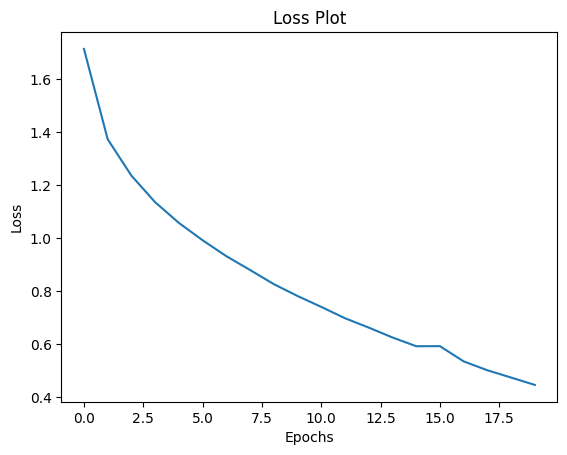

In [ ]:
EPOCHS = 50

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()
else:
    callbacks.append(early_stopping)
    best_loss = float('inf')

    for epoch in range(EPOCHS):
        start = time.time()
        total_loss = 0

        for (batch, (img_tensor, target)) in enumerate(dataset):
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss

            if batch % 100 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(
                    epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))

        epoch_loss = total_loss / num_steps
        loss_plot.append(epoch_loss)

        print('Epoch {} Loss {:.6f}'.format(epoch + 1, epoch_loss))
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

        # Sauvegarde du modèle uniquement si la perte est meilleure
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            ckpt_save_path = ckpt_manager.save()

    # Affichage de la courbe d'entrainement
    plt.plot(loss_plot)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Plot')
    plt.show()

#### Results

In [22]:
# Function to display attention on the image
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result // 2, len_result // 2, l + 1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', 
        alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Image Path: /tf/dataset_livrable_3/train2014/train2014/COCO_train2014_000000439241.jpg
Real Caption: a bathroom with a white toilet next to a sink
Predicted Caption: a bathroom with an interesting sink


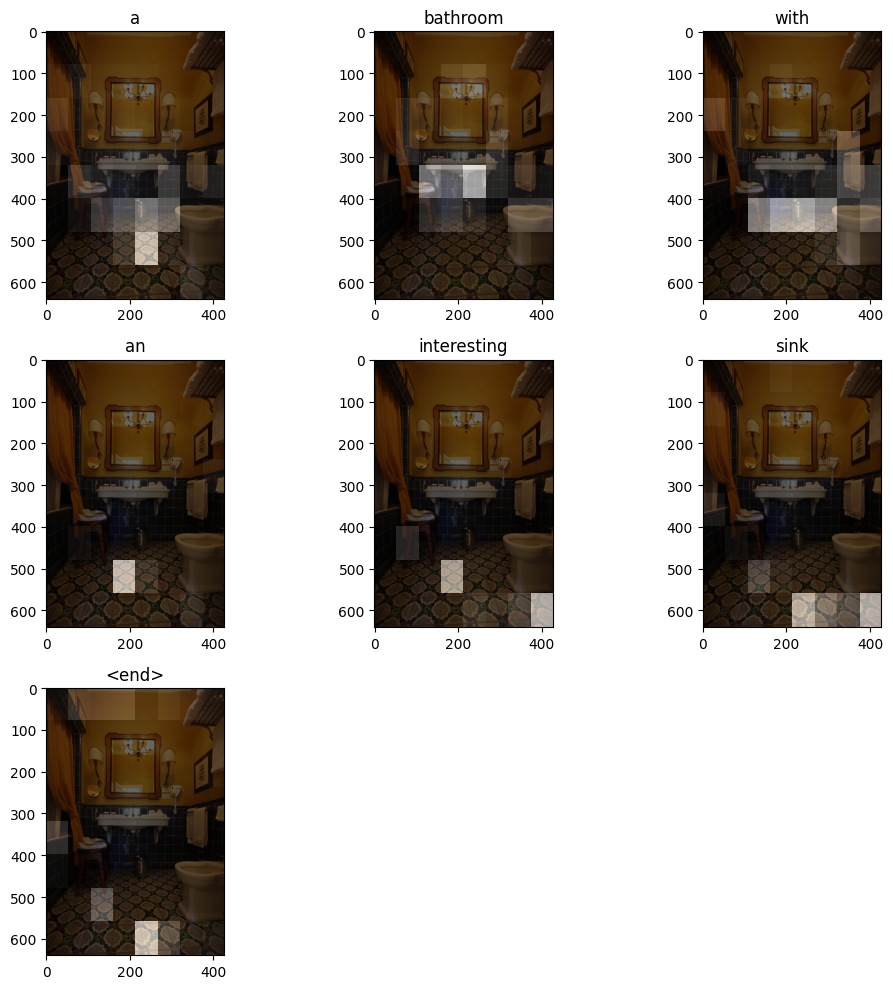

In [32]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            break

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

# Une seule image de départ
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
index = img_name_val.index(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[index] if i not in [0, tokenizer.word_index['<start>'], tokenizer.word_index['<end>']]])

# Evaluation répétée jusqu'à obtenir 3 prédictions consécutives identiques
previous_captions = []
streak = 1
last_caption = None

while True:
    result, attention_plot = evaluate(image)
    predicted_caption = ' '.join([word for word in result if word not in ['<start>', '<end>']])

    #print(predicted_caption)
    #print(last_caption)

    if predicted_caption == last_caption:
        streak += 1
    else:
        streak = 1
        last_caption = predicted_caption

    if streak == 2:
        print('Image Path:', image)
        print('Real Caption:', real_caption)
        print('Predicted Caption:', predicted_caption)
        plot_attention(image, result, attention_plot)
        break


In [ ]:
#def evaluate(image):
#    attention_plot = np.zeros((max_length, attention_features_shape))
#
#    hidden = decoder.reset_state(batch_size=1)
#
#    temp_input = tf.expand_dims(load_image(image)[0], 0)
#    img_tensor_val = image_features_extract_model(temp_input)
#    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
#
#    features = encoder(img_tensor_val)
#
#    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
#    result = []
#
#    for i in range(max_length):
#        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
#
#        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
#
#        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
#        result.append(tokenizer.index_word[predicted_id])
#
#        if tokenizer.index_word[predicted_id] == '<end>':
#            return result, attention_plot
#
#        dec_input = tf.expand_dims([predicted_id], 0)
#
#    attention_plot = attention_plot[:len(result), :]
#    return result, attention_plot

In [ ]:
#while True:
#    rid = np.random.randint(0, len(img_name_val))
#    image = img_name_val[rid]
#    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
#    
#    result, attention_plot = evaluate(image)
#    prediction_caption = ' '.join(result)
#
#    real_keywords = {word for word in real_caption.split() if len(word) > 2 and word not in ['<start>', '<end>']}
#    predicted_keywords = {word for word in prediction_caption.split() if len(word) > 2 and word not in ['<start>', '<end>']}
#    common_keywords = real_keywords.intersection(predicted_keywords)
#
#    if(len(common_keywords) >= 5):
#        print('Image Path:', image)
#        print('Real Caption:', real_caption)
#        print('Prediction Caption:', prediction_caption)
#        print('Common Keywords:', common_keywords)
#        plot_attention(image, result, attention_plot)
#        break
#